# Extended EDA & Statistical Hypothesis Testing

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

In [15]:
DATA_PATH = "../data/afterprocessing/processed_matches.csv"
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
print(f"Loaded dataset with {df.shape[0]} matches.")

Loaded dataset with 25979 matches.


## 1. Univariate Analysis: Distributions & Normality
We need to know if our continuous features (like 'elo_diff' or 'form') follow a Normal Distribution. This decides whether we use parametric (T-test/ANOVA) or non-parametric tests later.

In [ ]:
features_to_check = ['elo_diff', 'home_form_5', 'away_form_5', 'prob_diff_home', 'B365_prob_H']

fig, axes = plt.subplots(len(features_to_check), 2, figsize=(14, 4 * len(features_to_check)))

for i, feat in enumerate(features_to_check):
    # Histogram + KDE
    sns.histplot(df[feat].dropna(), kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Distribution of {feat}')
    
    # Q-Q Plot
    stats.probplot(df[feat].dropna(), dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot for {feat}')

plt.tight_layout()
plt.show()

# Kolmogorov-Smirnov Test for Normality (since N > 2000, Shapiro is too sensitive)
print("Normality Test Results (Kolmogorov-Smirnov):")
print("{:<20} {:<15} {:<15} {:<10}".format("Feature", "KS Statistic", "P-Value", "Normal?"))
print("-"*60)
for feat in features_to_check:
    data = df[feat].dropna()
    # Standardize data before KS test against standard normal
    data_std = (data - data.mean()) / data.std()
    stat, p = stats.kstest(data_std, 'norm')
    is_normal = "Yes" if p > 0.05 else "No"
    print("{:<20} {:<15.4f} {:<15.4e} {:<10}".format(feat, stat, p, is_normal))


## 2. Bivariate Analysis: Feature vs Target
Do features significantly differ between Winning, Drawing, and Losing teams?
We use **Box Plots** for visualization and **ANOVA** (if normal) or **Kruskal-Wallis** (if non-normal) for testing.

C:\Users\NhatMinh\AppData\Local\Temp\ipykernel_11288\951551422.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='result_label', y=feat, data=df, ax=axes[i], palette='Set2', order=['Home Win', 'Draw', 'Away Win'])
C:\Users\NhatMinh\AppData\Local\Temp\ipykernel_11288\951551422.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='result_label', y=feat, data=df, ax=axes[i], palette='Set2', order=['Home Win', 'Draw', 'Away Win'])
C:\Users\NhatMinh\AppData\Local\Temp\ipykernel_11288\951551422.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxp

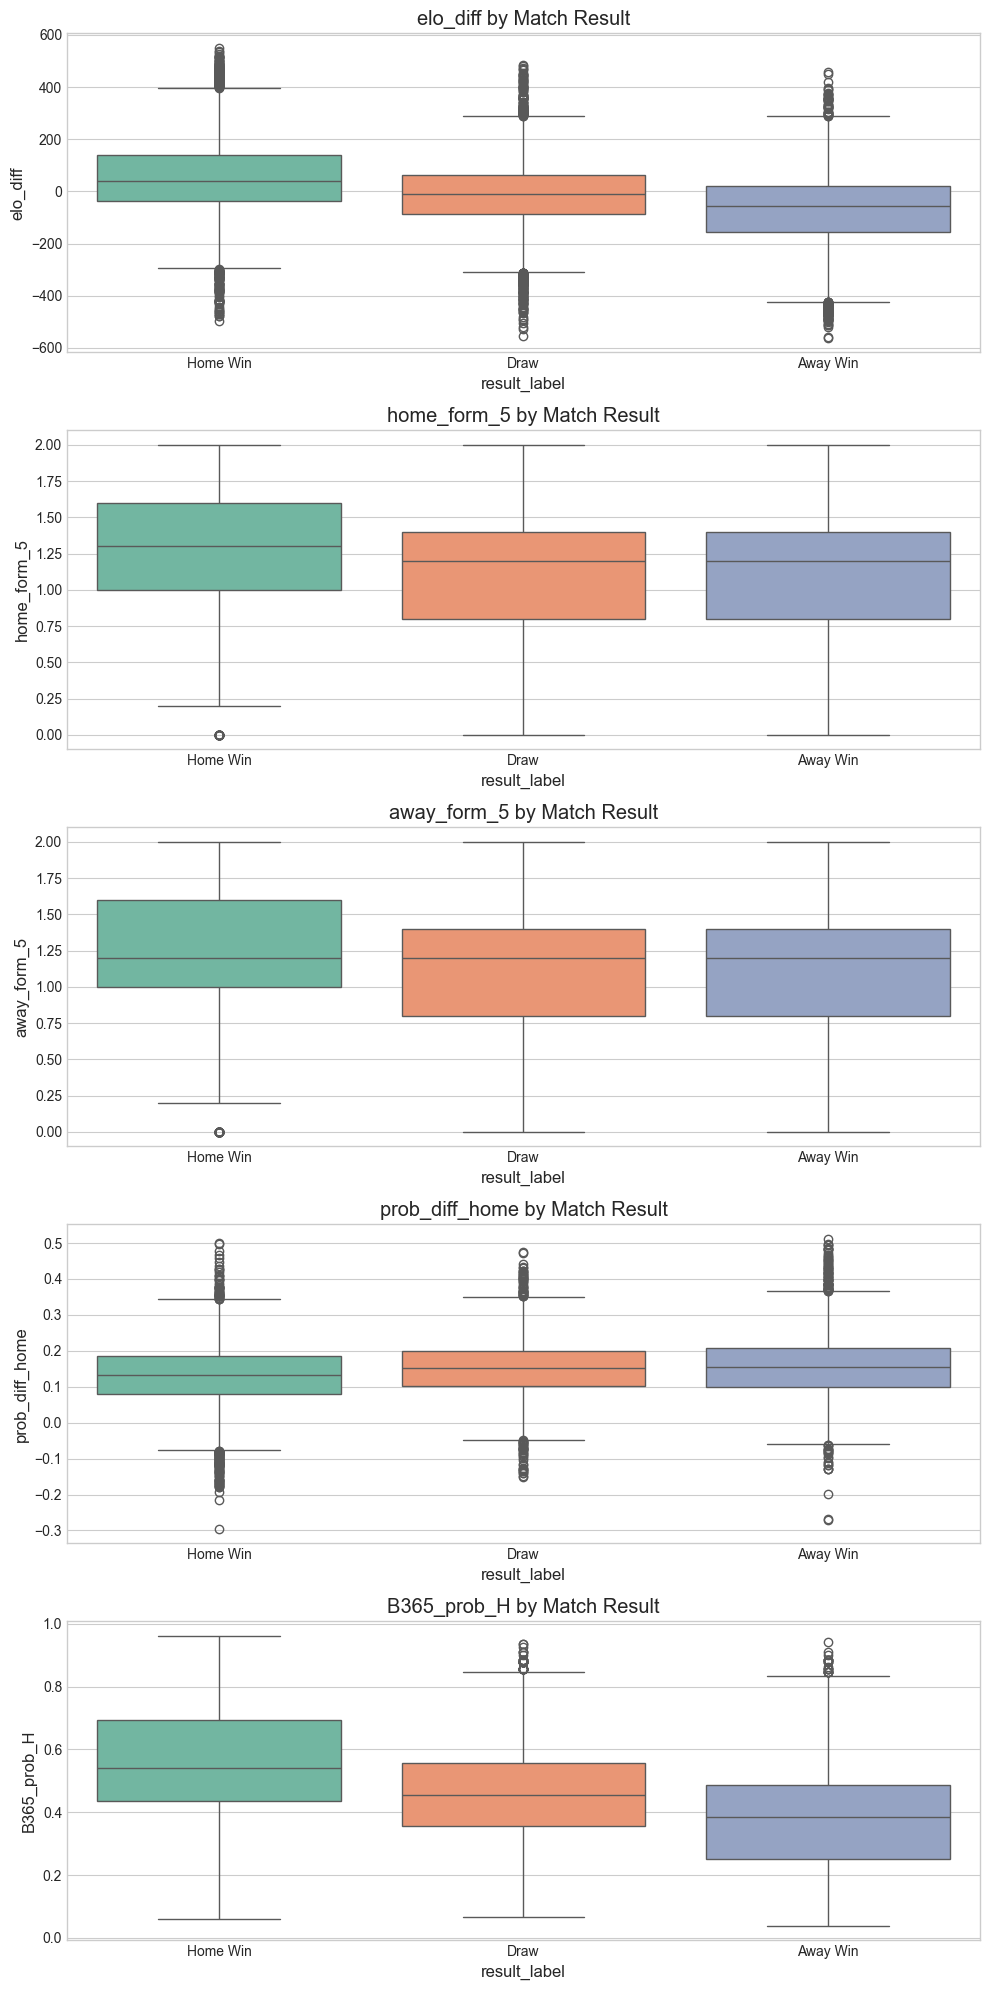

ANOVA Test (Difference on means across Result classes):
Feature              F-Statistic     P-Value        
--------------------------------------------------
elo_diff             1852.7125       0.0000e+00     
home_form_5          344.5274        2.1076e-148    
away_form_5          319.7460        6.5740e-138    
prob_diff_home       190.7862        6.8336e-83     
B365_prob_H          2229.3318       0.0000e+00     


In [17]:
target_labels = {0: 'Away Win', 1: 'Draw', 2: 'Home Win'}
df['result_label'] = df['target'].map(target_labels)

fig, axes = plt.subplots(len(features_to_check), 1, figsize=(10, 4 * len(features_to_check)))

for i, feat in enumerate(features_to_check):
    sns.boxplot(x='result_label', y=feat, data=df, ax=axes[i], palette='Set2', order=['Home Win', 'Draw', 'Away Win'])
    axes[i].set_title(f'{feat} by Match Result')

plt.tight_layout()
plt.show()

# Statistical Significance (ANOVA)
print("ANOVA Test (Difference on means across Result classes):")
print("{:<20} {:<15} {:<15}".format("Feature", "F-Statistic", "P-Value"))
print("-"*50)
for feat in features_to_check:
    group_HW = df[df['target']==2][feat].dropna()
    group_D = df[df['target']==1][feat].dropna()
    group_AW = df[df['target']==0][feat].dropna()
    
    f_stat, p = stats.f_oneway(group_HW, group_D, group_AW)
    print("{:<20} {:<15.4f} {:<15.4e}".format(feat, f_stat, p))

## 3. Multivariate Analysis: Feature Correlations
We check potential multicollinearity.

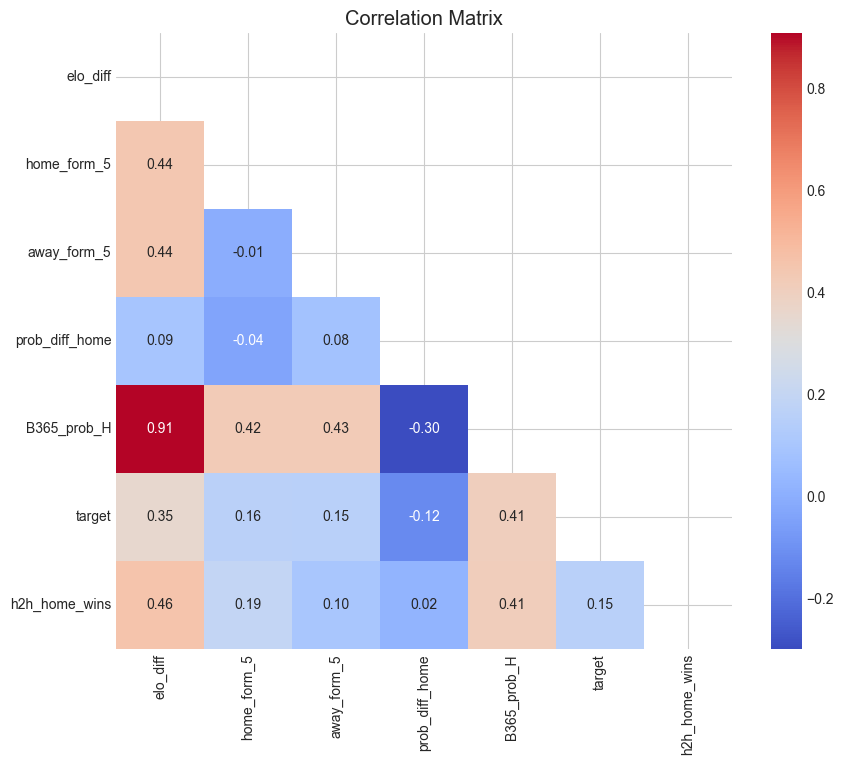

In [18]:
numeric_df = df[features_to_check + ['target', 'h2h_home_wins']]
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

## 4. Special Hypothesis Tests (Football Specific)

### 4.1 Poisson Distribution for Goals

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
C:\Users\NhatMinh\AppData\Local\Temp\ipykernel_11288\470060404.py:9: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(k, poisson.pmf(k, mu), 'ro-', label=f'Poisson ($\lambda$={mu:.2f})')


Home Goals Poisson Fit: lambda=1.54, Chi2=109.43, p=1.9240e-19
Away Goals Poisson Fit: lambda=1.16, Chi2=222.99, p=4.9113e-43


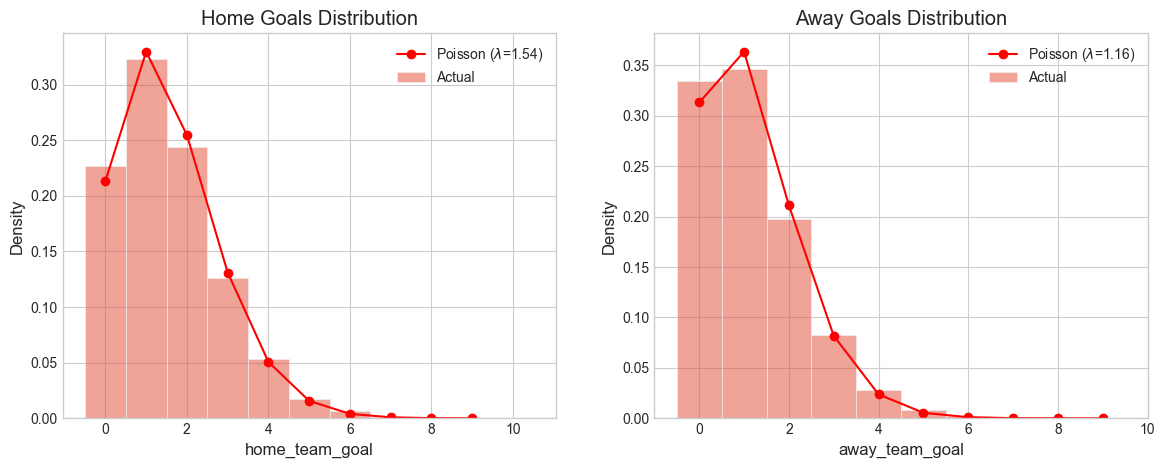

In [19]:
from scipy.stats import poisson

def check_poisson(data, name, ax):
    mu = data.mean()
    k = np.arange(0, 10)
    
    # Plot
    sns.histplot(data, bins=range(0,11), discrete=True, stat='density', ax=ax, label='Actual', alpha=0.5)
    ax.plot(k, poisson.pmf(k, mu), 'ro-', label=f'Poisson ($\lambda$={mu:.2f})')
    ax.set_title(f'{name} Distribution')
    ax.legend()
    
    # Goodness of Fit Test (Chi-Square)
    # Bin counts observed vs expected
    obs_counts = data.value_counts().sort_index()
    # Filter to only checked range
    obs_counts = obs_counts[obs_counts.index < 10]
    relevant_k = obs_counts.index.values
    exp_prob = poisson.pmf(relevant_k, mu)
    exp_counts = exp_prob * len(data)
    
    # Normalize expected to sum to observed (approx)
    exp_counts = exp_counts * (obs_counts.sum() / exp_counts.sum())
    
    chisq, p = stats.chisquare(obs_counts, exp_counts)
    return mu, chisq, p

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
mu_h, chi_h, p_h = check_poisson(df['home_team_goal'], 'Home Goals', axes[0])
mu_a, chi_a, p_a = check_poisson(df['away_team_goal'], 'Away Goals', axes[1])

print(f"Home Goals Poisson Fit: lambda={mu_h:.2f}, Chi2={chi_h:.2f}, p={p_h:.4e}")
print(f"Away Goals Poisson Fit: lambda={mu_a:.2f}, Chi2={chi_a:.2f}, p={p_a:.4e}")

### 4.2 Top Scorer Impact
Does having a Top Scorer change the outcome distribution?

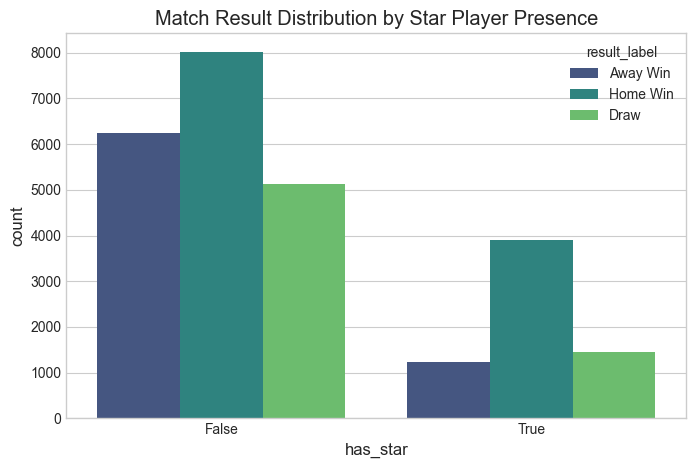

Star Player Chi-Square Test: p-value = 1.2595e-149


In [20]:
if 'home_star_players' in df.columns:
    df['has_star'] = df['home_star_players'] > 0
    
    # Visualize
    plt.figure(figsize=(8, 5))
    sns.countplot(x='has_star', hue='result_label', data=df, palette='viridis')
    plt.title('Match Result Distribution by Star Player Presence')
    plt.show()
    
    # Chi-Square Test
    ct = pd.crosstab(df['has_star'], df['target'])
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    print(f"Star Player Chi-Square Test: p-value = {p:.4e}")

## 5. Seasonality Analysis
Trends over time.

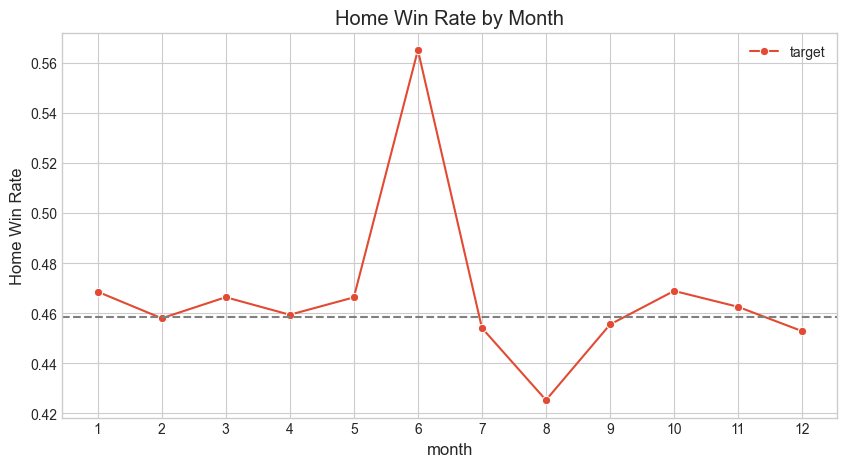

In [21]:
df['month'] = df['date'].dt.month
monthly_stats = df.groupby('month')[['target']].apply(lambda x: (x==2).mean())

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_stats, marker='o', color='purple')
plt.axhline(df[df['target']==2].shape[0]/len(df), color='gray', linestyle='--')
plt.title('Home Win Rate by Month')
plt.ylabel('Home Win Rate')
plt.xticks(range(1, 13))
plt.show()